In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Open file

In [17]:
file_path = 'Trips_2018.csv'

if not os.path.exists('plots'):
    os.makedirs('plots')

with open(file_path, 'r') as f:
    df = pd.read_csv(f)

Sample the data (can be removed completely later)

In [18]:
df = df.drop(df.columns[0], axis=1) # We are dropping the first coolumn because it is just an index
df = df.sample(n=10000, random_state=42)

Remove null values for start_station_id and end_station_id

In [19]:
df = df[pd.to_numeric(df['start_station_id'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['end_station_id'], errors='coerce').notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 16303534 to 4635301
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tripduration             9999 non-null   int64  
 1   starttime                9999 non-null   object 
 2   stoptime                 9999 non-null   object 
 3   start_station_id         9999 non-null   float64
 4   start_station_latitude   9999 non-null   float64
 5   start_station_longitude  9999 non-null   float64
 6   end_station_id           9999 non-null   float64
 7   end_station_latitude     9999 non-null   float64
 8   end_station_longitude    9999 non-null   float64
 9   bikeid                   9999 non-null   int64  
 10  usertype                 9999 non-null   object 
 11  birth_year               9999 non-null   int64  
 12  gender                   9999 non-null   int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 1.1+ MB


Clean up the data

In [20]:
# Convert start_time and end_time columns to datetime format
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])

# Extract date, hour, and day of the week from start_time column
df['date'] = df['starttime'].dt.date
df['hour'] = df['starttime'].dt.hour
df['day_of_week'] = df['starttime'].dt.dayofweek

# Drop any rows with null values
df = df.dropna()

# Drop any rows with negative trip durations
df = df[df['tripduration'] > 0]

# Drop any rows with trip durations greater than 24 hours
df = df[df['tripduration'] <= 86400]
# Drop rows that are outside the 99th percentile of trip durations
df = df[df['tripduration'] <= df['tripduration'].quantile(.99)]

# Drop rows where the birth_year is outside the 99th percentile of birth years
df = df[df['birth_year'] >= df['birth_year'].quantile(.01)]

# Drop rows where the gender is not 0, 1
df = df[df['gender'].isin([0, 1])]

# Encode 

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7522 entries, 16303534 to 13020498
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   tripduration             7522 non-null   int64         
 1   starttime                7522 non-null   datetime64[ns]
 2   stoptime                 7522 non-null   datetime64[ns]
 3   start_station_id         7522 non-null   float64       
 4   start_station_latitude   7522 non-null   float64       
 5   start_station_longitude  7522 non-null   float64       
 6   end_station_id           7522 non-null   float64       
 7   end_station_latitude     7522 non-null   float64       
 8   end_station_longitude    7522 non-null   float64       
 9   bikeid                   7522 non-null   int64         
 10  usertype                 7522 non-null   object        
 11  birth_year               7522 non-null   int64         
 12  gender                   752

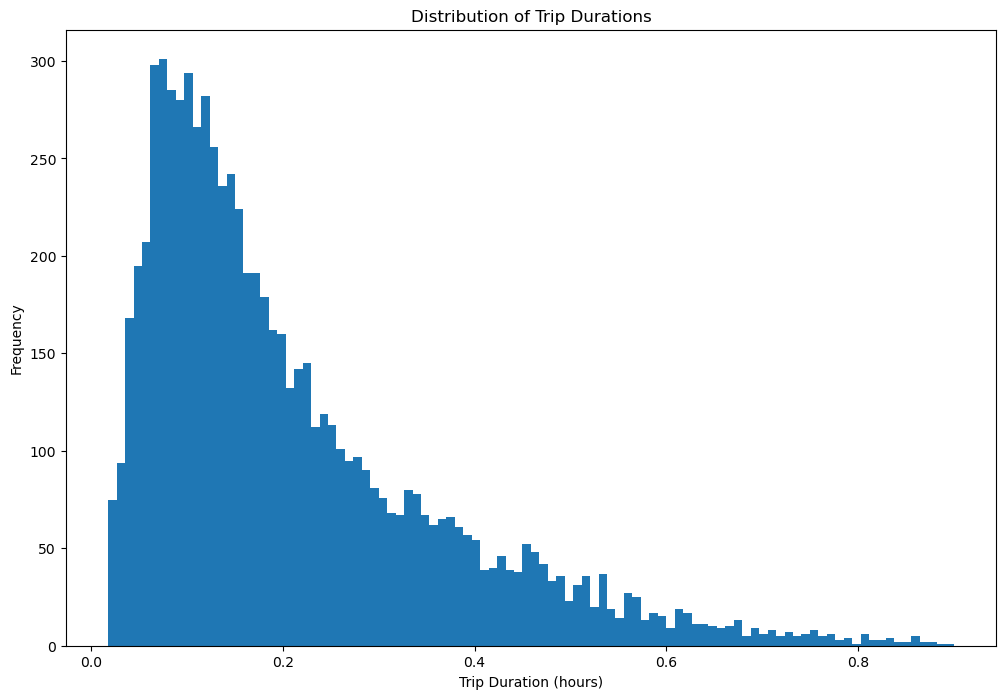

In [21]:
# Time series of trip durations
plt.figure(figsize=(12, 8))
plt.hist(df['tripduration']/3600, bins=100)
plt.xlabel('Trip Duration (hours)')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Durations')
plt.savefig('plots/trip_durations.png')
plt.show()


Further processing with K-means clustering to remove locations we don't care about

In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#Finding the optimal number of clusters with elbow method

# Extract coordinates from the sample
coordinates_start = df[['start_station_latitude', 'start_station_longitude']]
coordinates_end = df[['end_station_latitude', 'end_station_longitude']]

#Standardize the coordinates
scaler = StandardScaler()
coordinates_standardized = scaler.fit_transform(coordinates_start)

#Elbow method
# distortions = []
# K = range(1, 40)  
# for k in K:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(coordinates_standardized)
#     distortions.append(kmeans.inertia_)

# # Plot the Elbow curve
# plt.figure(figsize=(12, 6))
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('Number of clusters (k)')
# plt.ylabel('Distortion (Inertia)')
# plt.title('Elbow Method for Optimal k with Sampled Data')
# plt.show()

# Plot K-means with 20 clusters
kmeans = KMeans(n_clusters=20, random_state=42)
kmeans.fit(coordinates_standardized)
df['cluster'] = kmeans.predict(coordinates_standardized)

# Cluster the data into 20 clusters
kmeans = KMeans(n_clusters=20, init='k-means++', random_state=42).fit(coordinates_start)

# Get the cluster centers
centers = kmeans.cluster_centers_

# Add the cluster labels to the dataframe
df['cluster'] = kmeans.predict(coordinates_start)

/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Plot the clusters on a map

In [23]:
import plotly.express as px

def plot_stations_map(stations):
    #First before plotting we have to deal with the outliers 
    #The latitude of New York City is approximately between 40.4774 and 45.01585, and the longitude is approximately between -79.76259 and -71.18507.

    lon_min = -79.76259
    lat_min = 40.4774
    lon_max = -71.18507
    lat_max = 45.01585

    # Store the stations that are within the boundaries
    stations = stations[
        (stations['start_station_latitude'] > lat_min) &
        (stations['start_station_latitude'] < lat_max) &
        (stations['start_station_longitude'] > lon_min) &
        (stations['start_station_longitude'] < lon_max)
    ]
    
    #Plot the stations with an underlying map of New York City
    title = 'Citi Bike Stations in New York City'
    fig = px.scatter_mapbox(
        stations,
        lat='start_station_latitude',
        lon='start_station_longitude',
        color='cluster',
        mapbox_style='carto-positron',
        zoom=9,
        width=1000,
        height=600
    )
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,  # Center the title horizontally
            xanchor='center',  # Anchor point for horizontal alignment
            font=dict(size=20)
        )
    )
    fig.show()


Remove the locations that are more than 3 standard deviations from the center of the clusters

In [24]:
# Calculate the distance between each point and its cluster center
distance = kmeans.transform(coordinates_start)

# Get the minimum distance for each point and its cluster index
min_distance = np.min(distance, axis=1)
min_distance_cluster = np.argmin(distance, axis=1)

threshold = 0.015

# Get the indices of the points that are within the threshold distance of a cluster center
within_threshold = np.argwhere(min_distance < threshold).flatten()

# Remove the points that are outside the threshold distance of a cluster center
df = df.iloc[within_threshold]

# Plot the stations with an underlying map of New York City
plot_stations_map(df)

Find the most important cluster and get all the relevant values from the dataframe based on it (MVC - Most Valuable Cluster)

In [37]:
# Sort the clusters by the number of trips (instances) in each cluster 
sorted_clusters= df['cluster'].value_counts().idxmax()

# Get the indices of the points that are in the most important cluster
most_important_cluster_indices = np.argwhere(df['cluster'] == sorted_clusters).flatten()

# Get the most important cluster's features
MVC = df.iloc[most_important_cluster_indices].copy()
MVC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707 entries, 10376436 to 14863760
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   tripduration             707 non-null    int64         
 1   starttime                707 non-null    datetime64[ns]
 2   stoptime                 707 non-null    datetime64[ns]
 3   start_station_id         707 non-null    float64       
 4   start_station_latitude   707 non-null    float64       
 5   start_station_longitude  707 non-null    float64       
 6   end_station_id           707 non-null    float64       
 7   end_station_latitude     707 non-null    float64       
 8   end_station_longitude    707 non-null    float64       
 9   bikeid                   707 non-null    int64         
 10  usertype                 707 non-null    object        
 11  birth_year               707 non-null    int64         
 12  gender                   707 

Linear Regression model for predicting the trip duration

In [ ]:
from sklearn.preprocessing import StandardScaler

# Extract the features
features = MVC[['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'hour']]

# Standardize the features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

# Use the most important cluster's features to fit a Linear Regression (LR) model
from sklearn.linear_model import LinearRegression

# Extract the target variable
target = MVC['tripduration']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_standardized, target, test_size=0.2, random_state=42)

# Fit a Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

error = y_test - y_pred

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

Plot the Linear Regression model results

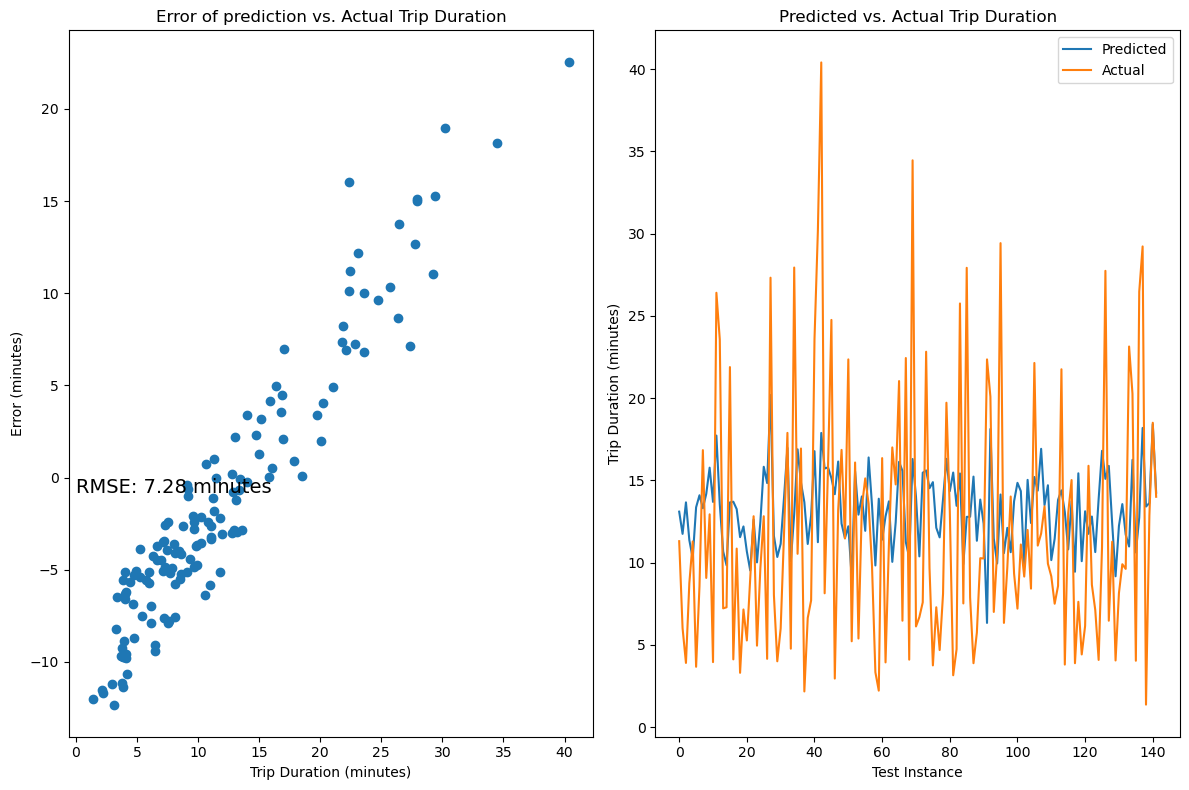

In [71]:
# Plot the error
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.scatter(y_test/60, error/60)
plt.text(0, 0, 'RMSE: {:.2f} minutes'.format(rmse/60), fontsize=14, va='top')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Error (minutes)')
plt.title('Error of prediction vs. Actual Trip Duration')
plt.subplot(1, 2, 2)
plt.plot(y_pred/60, label='Predicted')
plt.plot(y_test.values/60, label='Actual')
plt.xlabel('Test Instance')
plt.ylabel('Trip Duration (minutes)')
plt.title('Predicted vs. Actual Trip Duration')
plt.legend()
plt.tight_layout()
plt.savefig('plots/linear_regression.png')
plt.show()

Random Forest model for predicting the trip duration

In [72]:
from sklearn.ensemble import RandomForestRegressor

# Fit a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

RMSE: 277.68948435898955


Print the Random Forest model results

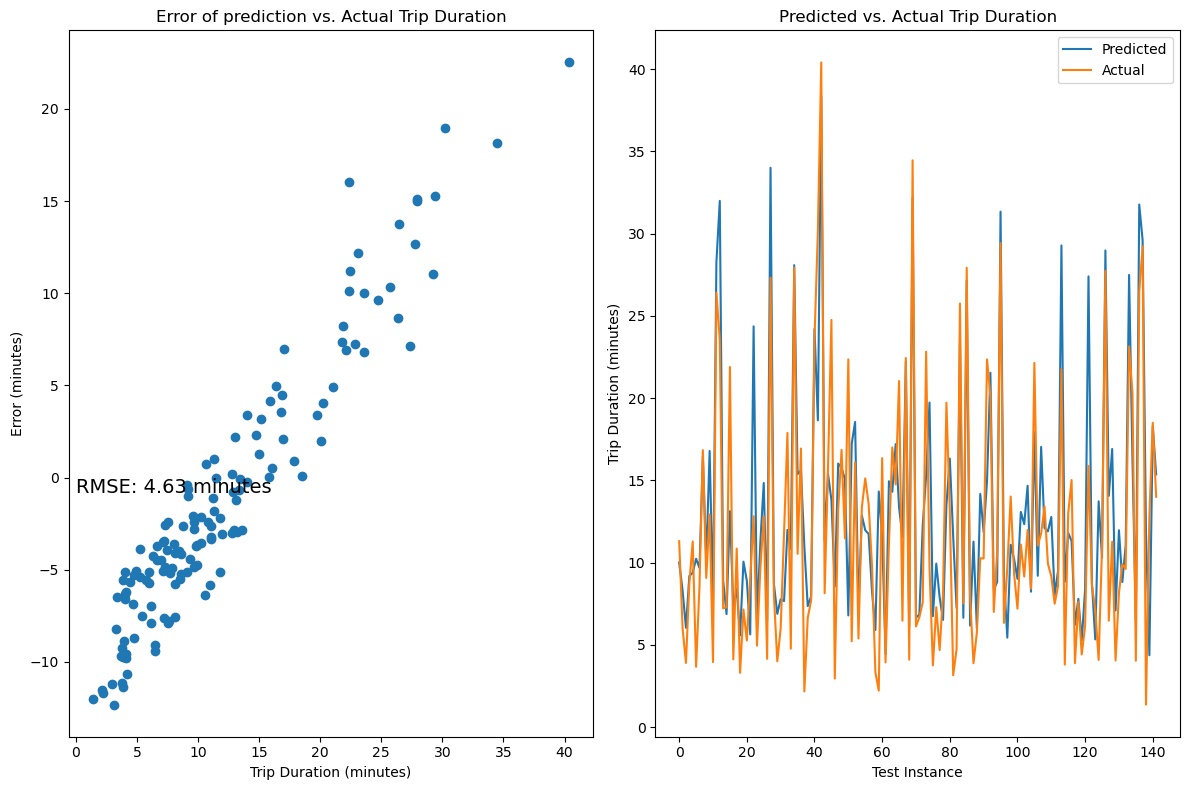

In [73]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.scatter(y_test/60, error/60)
plt.text(0, 0, 'RMSE: {:.2f} minutes'.format(rmse/60), fontsize=14, va='top')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Error (minutes)')
plt.title('Error of prediction vs. Actual Trip Duration')
plt.subplot(1, 2, 2)
plt.plot(y_pred/60, label='Predicted')
plt.plot(y_test.values/60, label='Actual')
plt.xlabel('Test Instance')
plt.ylabel('Trip Duration (minutes)')
plt.title('Predicted vs. Actual Trip Duration')
plt.legend()
plt.tight_layout()
plt.savefig('plots/random_forest.png')
plt.show()
